<h1 align="center"> Deep Reinforcement Learning for Robotic Systems </h1>

## Synopsis

This notebook outlines the mathematical modelling of an **inverted double pendulum** with the integration of the **[Proximal Policy Optimisation](http://arxiv.org/abs/1707.06347)** algorithm as the control system. This project serves as a baseline study into advanced autonomous control systems facilitating the control of multibody, variable mass dynamical systems, such as docking and berthing of spacecraft, and rocket trajectory stabilisation. 

--------
Produced by *[Mughees Asif](https://github.com/mughees-asif)*, under the supervision of [Dr. Angadh Nanjangud](https://www.sems.qmul.ac.uk/staff/a.nanjangud) (Lecturer in Aerospace/Spacecraft Engineering @ [Queen Mary, University of London](https://www.sems.qmul.ac.uk/)).

## Contents<a class="anchor" id="contents"></a>

**1. [Overview](#overview)<br />**

**2. [Model](#model)<br />**
&emsp;2.1. [Description](#model-description)<br />

**3. [Governing Equations of Motion](#governing-eqs-motion)<br />**
&emsp;3.1. [Library Imports](#library-imports)<br />
&emsp;3.2. [Variable Declaration](#var-dec)<br />
&emsp;3.3. [Kinetic and Potential Energy](#kinetic-potential)<br />
&emsp;3.4. [The Lagrangian](#lagrangian)<br />
&emsp;3.5. [The Euler-Lagrange Equations](#euler-lagrange)<br />
&emsp;3.6. [Linearisation and Acceleration](#linearisation)<br />

**4. [Proximal Policy Optimisation](#ppo)**<br />
&emsp;4.1. [Overview](#ppo-overview)<br />
&emsp;4.2. [Mathematical Model](#ppo-math)<br />
&emsp;4.3. [Neural Network](#ppo-nn)<br />
&emsp;&emsp;&emsp;*4.3.1. [Actor](#ppo-nn-actor)<br />*
&emsp;&emsp;&emsp;*4.3.2. [Critic](#ppo-nn-critic)<br />*
&emsp;&emsp;&emsp;*4.3.3. [Agent](#ppo-nn-agent)<br />*
&emsp;4.4. [Environment](#ppo-env)<br />
&emsp;4.5. [Test](#ppo-test)<br />

**5. [Conclusion](#conclusion)**<br />
&emsp;5.1. [$\theta = 0.05,\;\;\phi = 0.05$](#conclusion-1)<br />
&emsp;5.2. [$\theta = 0.10,\;\;\phi = 0.10$](#conclusion-2)<br />
&emsp;5.3. [$\theta = 0.15,\;\;\phi = 0.15$](#conclusion-3)<br />

---
#### Press [☝](#contents) to return to the contents.

## 1. Overview <a class="anchor" id="overview"></a>  [☝](#contents)

Proximal Policy Optimisation is a deep reinforcement learning algorithm developed by [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html). It has proven to be successful in a variety of tasks ranging from enabling robotic systems in complex environments, to developing proficiency in computer gaming by using stochastic mathematical modelling to simulate real-life decision making. For the purposes of this research, the algorithm will be implemented to vertically stablise an inverted double pendulum, which is widely used in industry as a benchmark to validate the veracity of next-generation intelligent algorithms.

## 2. Model <a class="anchor" id="model"></a> [☝](#contents)

<img src="images/dip_fbd.png" width="350" title="Inverted Double Pendulum"/>

| Name | Symbol |
| :-: | :-: | 
| Mass of the cart | $$m$$ | 
| Mass of the pendulums | $$M_1 = M_2 = M$$ |
| Length of the pendulums | $$l_1 = l_2 = l$$ |
| Angle of the first pendulum <br/> w.r.t the vertical (CCW+) | $$\theta$$ |
| Angle of the second pendulum <br/> w.r.t the first pendulum (CCW+) | $$\phi$$ |
| Moment of inertia for the pendulums | $$I_1 = I_2 = I$$ |
| Horizontal cart position | $$x$$ |
| Horizontal force applied to the cart | $$u$$ |
| Gravitational constant | $$g$$ |

### 2.1. Description <a class="anchor" id="model-description"></a> [☝](#contents)

An inverted double pendulum is a characteristic example of a holonomic, simple-to-build, non-linear, and chaotic mechanical system that has been widely studied in the fields of Robotics, Aerospace, Biomedical, Mechanical Engineering, and Mathematical Analysis.

## 3. Governing Equations of Motion <a class="anchor" id="governing-eqs-motion"></a> [☝](#contents)

The following section utilises the [SymPy](https://www.sympy.org/en/index.html) package to derive the governing equations of motion. 

### 3.1. Library Imports <a class="anchor" id="library-imports"></a> [☝](#contents)

In [1]:
# mathematical
import sympy

# computational
import matplotlib.pyplot as plt
import math
import time
import gym
import seeding 
import numpy as np
import torch as T 
import torch.nn as nn 
import torch.optim as optim
from torch.distributions.categorical import Categorical 

### 3.2. Variable Declaration <a class="anchor" id="var-dec"></a> [☝](#contents)

In [2]:
# initiliase variables
t = sympy.symbols('t')        # time
m = sympy.symbols('m')        # mass of the cart
l = sympy.symbols('l')        # length of the pendulums, l_1 = l_2 = l
M = sympy.symbols('M')        # mass of the pendulums, M_1 = M_2 = M
I = sympy.symbols('I')        # moment of inertia
g = sympy.symbols('g')        # gravitational constant
u = sympy.symbols('u')        # force applied to the cart (horizontal component)

x = sympy.Function('x')(t)    # |
Θ = sympy.Function('Θ')(t)    # | --- functions of time `t`
Φ = sympy.Function('Φ')(t)    # |

# cart
x_dot = x.diff(t)             # velocity

# pendulum(s) 
Θ_dot = Θ.diff(t)               # | 
Θ_ddot = Θ_dot.diff(t)          # |
Φ_dot = Φ.diff(t)               # |
Φ_ddot = Φ_dot.diff(t)          # |
cos_theta = sympy.cos(Θ)        # | --- experimental parameters
sin_theta = sympy.sin(Θ)        # |
cos_thetaphi = sympy.cos(Θ - Φ) # |
cos_phi = sympy.cos(Φ)          # |
sin_phi = sympy.sin(Φ)          # |

### 3.3. Kinetic (K.E.) and Potential (P.E.) Energy <a class="anchor" id="kinetic-potential"></a> [☝](#contents)


<img src="images/dip_fbd_radius.png" width="300" title="Angular Trajectory of the Inverted Double Pendulum"/>

\begin{equation*} 
\because K.E._{T}= K.E._{C} + K.E._{1} + K.E._{2}
\label{eq:ke_4} 
\end{equation*}

\begin{equation*} 
\because P.E._{T}= P.E._{C} + P.E._{1} + P.E._{2}
\end{equation*}

---

\begin{equation*} 
K.E._{C}=\frac{1}{2}m{\dot{x}^2} 
\label{eq:ke_1} \tag{1} 
\end{equation*}

\begin{equation*} 
K.E._{1}=\frac{1}{2}M\left[\dot{x}\left(\dot{x}+2l\dot{\theta{}}\cos{\theta{}}\right)+{\dot{\theta{}}}^2\left(Ml^2+I\right)\right] 
\label{eq:ke_2} \tag{2} 
\end{equation*}

\begin{equation*} 
K.E._{2}=\frac{1}{2}\left[{\dot{x}}^2+l^2{\dot{\theta{}}}^2+{\dot{\phi{}}}^2\left(Ml^2+I\right)+Ml\dot{\theta{}}\dot{\phi{}}\cos{\left(\theta{}-\phi{}\right)}+2Ml\dot{x}\left(\dot{\theta{}}\cos{\theta{}}+\dot{\phi{}}\cos{\phi{}}\right)\right] 
\label{eq:ke_3} \tag{3} 
\end{equation*}

\begin{equation*} 
\therefore \boldsymbol{K.E._{T}=\frac{1}{2}\left[m{\dot{x}}^2+M\dot{x}\left(\dot{x}+2l\dot{\theta{}}\cos{\theta{}}\right)+{\dot{\theta{}}}^2\left(Ml^2+I\right)+{\dot{x}}^2+l^2{\dot{\theta{}}}^2+\\{\dot{\phi{}}}^2\left(Ml^2+I\right)+Ml\dot{\theta{}}\dot{\phi{}}\cos{\left(\theta{}-\phi{}\right)}+2Ml\dot{x}\left(\dot{\theta{}}\cos{\theta{}}+\dot{\phi{}}\cos{\phi{}}\right)\right]}
\label{eq:ke_5} \tag{4} 
\end{equation*}

---

\begin{equation*} 
P.E._{C}=0
\tag{5} 
\end{equation*}

\begin{equation*} 
P.E._{1}=Mgl\cos{\theta}
\tag{6} 
\end{equation*}

\begin{equation*} 
P.E._{2}=Mgl\cos{\theta} + Mgl\cos{\phi}
\tag{7} 
\end{equation*}

\begin{equation*} 
\therefore \boldsymbol{P.E._{T}=Mgl(2\cos{\theta} + \cos{\phi})}
\tag{8} 
\end{equation*}

In [3]:
# kinetic energy components
# cart - linear
k_1 = m*x_dot**2         

# pendulum(s) - angular
k_2 = (M*x_dot*(x_dot + 2*l*Θ_dot*cos_theta) + Θ_dot**2*(M*(l**2)+I))
k_3 = (x_dot**2) + (l**2*Θ_dot**2) + (Φ_dot**2*(M*(l**2)+I) \
       + (M*l*Θ_dot*Φ_dot*cos_thetaphi) + \
       (2*M*l*x_dot*((Θ_dot*cos_theta) + (Φ_dot*cos_phi))))

In [4]:
# total kinetic energy
K = 0.5*(k_1 + k_2 + k_3)

print('----\nThe kinetic energy, K, of the system:\n----')
K

----
The kinetic energy, K, of the system:
----


1.0*M*l*(cos(Θ(t))*Derivative(Θ(t), t) + cos(Φ(t))*Derivative(Φ(t), t))*Derivative(x(t), t) + 0.5*M*l*cos(Θ(t) - Φ(t))*Derivative(Θ(t), t)*Derivative(Φ(t), t) + 0.5*M*(2*l*cos(Θ(t))*Derivative(Θ(t), t) + Derivative(x(t), t))*Derivative(x(t), t) + 0.5*l**2*Derivative(Θ(t), t)**2 + 0.5*m*Derivative(x(t), t)**2 + 0.5*(I + M*l**2)*Derivative(Θ(t), t)**2 + 0.5*(I + M*l**2)*Derivative(Φ(t), t)**2 + 0.5*Derivative(x(t), t)**2

In [5]:
# total potential energy
P = M*g*l*((2*cos_theta) + cos_phi)

print('----\nThe potential energy, P, of the system:\n----')
P

----
The potential energy, P, of the system:
----


M*g*l*(2*cos(Θ(t)) + cos(Φ(t)))

### 3.4. The Lagrangian <a class="anchor" id="lagrangian"></a> [☝](#contents)

The action $S$ of the cart (movement; left, right) is mathematically defined as:

$$\because S = \int_{t_{0}}^{t_{1}} K - P \,dt$$

and since, $L = K - P,$

$$\therefore S = \int_{t_{0}}^{t_{1}} L \,dt$$

where,

\begin{equation*} 
\boldsymbol{L=\frac{1}{2}\left[m{\dot{x}}^2+M\dot{x}\left(\dot{x}+2l\dot{\theta{}}\cos{\theta{}}\right)+{\dot{\theta{}}}^2\left(Ml^2+I\right)+{\dot{x}}^2+l^2{\dot{\theta{}}}^2+\\{\dot{\phi{}}}^2\left(Ml^2+I\right)+Ml\dot{\theta{}}\dot{\phi{}}\cos{\left(\theta{}-\phi{}\right)}+2Ml\dot{x}\left(\dot{\theta{}}\cos{\theta{}}+\dot{\phi{}}\cos{\phi{}}\right)\right] - Mgl(2\cos{\theta} + \cos{\phi})}
\tag{9} 
\end{equation*}

In [6]:
# the lagrangian
L = K - P

print('----\nThe Lagrangian of the system is:\n----')
L

----
The Lagrangian of the system is:
----


-M*g*l*(2*cos(Θ(t)) + cos(Φ(t))) + 1.0*M*l*(cos(Θ(t))*Derivative(Θ(t), t) + cos(Φ(t))*Derivative(Φ(t), t))*Derivative(x(t), t) + 0.5*M*l*cos(Θ(t) - Φ(t))*Derivative(Θ(t), t)*Derivative(Φ(t), t) + 0.5*M*(2*l*cos(Θ(t))*Derivative(Θ(t), t) + Derivative(x(t), t))*Derivative(x(t), t) + 0.5*l**2*Derivative(Θ(t), t)**2 + 0.5*m*Derivative(x(t), t)**2 + 0.5*(I + M*l**2)*Derivative(Θ(t), t)**2 + 0.5*(I + M*l**2)*Derivative(Φ(t), t)**2 + 0.5*Derivative(x(t), t)**2

### 3.5. The Euler-Lagrange Equations <a class="anchor" id="euler-lagrange"></a> [☝](#contents)

The standard [Euler-Lagrange equation](https://www.ucl.ac.uk/~ucahmto/latex_html/chapter2_latex2html/node5.html) is:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = 0$$

To introduce the generalised force $Q^{P}$ acting on the cart, the [Lagrange-D'Alembert Principle](https://en.wikipedia.org/wiki/D%27Alembert%27s_principle) is used:

\begin{equation}
\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = Q^{P}
\tag{10}
\end{equation}

Therefore, for a three-dimensional _working_ system, the equations of motion can be derived as:

\begin{equation}
\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = u
\tag{11}
\end{equation}

\begin{equation}
\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0
\tag{12}
\end{equation}

\begin{equation}
\frac{d}{dt}\frac{\partial L}{\partial \dot{\phi}} - \frac{\partial L}{\partial \phi} = 0
\tag{13}
\end{equation}

In [7]:
# euler-lagrange formulation
"""
`expand()`: allows cancellation of like terms
`collect()`: collects common powers of a term in an expression
"""

euler_1 = sympy.Eq((L.diff(x_dot).diff(t) - L.diff(x)).simplify().expand().collect(x.diff(t, t)), u)
euler_2 = sympy.Eq((L.diff(Θ_dot).diff(t) - L.diff(Θ)).simplify().expand().collect(Θ.diff(t, t)), 0)
euler_3 = sympy.Eq((L.diff(Φ_dot).diff(t) - L.diff(Φ)).simplify().expand().collect(Φ.diff(t, t)), 0)

In [8]:
print('----\nThe Euler-Lagrange equations:\n----\n1.\n----')
euler_1

----
The Euler-Lagrange equations:
----
1.
----


Eq(-2.0*M*l*sin(Θ(t))*Derivative(Θ(t), t)**2 - 1.0*M*l*sin(Φ(t))*Derivative(Φ(t), t)**2 + 2.0*M*l*cos(Θ(t))*Derivative(Θ(t), (t, 2)) + 1.0*M*l*cos(Φ(t))*Derivative(Φ(t), (t, 2)) + (1.0*M + 1.0*m + 1.0)*Derivative(x(t), (t, 2)), u)

In [9]:
print('----\n2.\n----')
euler_2

----
2.
----


Eq(-2.0*M*g*l*sin(Θ(t)) + 0.5*M*l*sin(Θ(t) - Φ(t))*Derivative(Φ(t), t)**2 + 0.5*M*l*cos(Θ(t) - Φ(t))*Derivative(Φ(t), (t, 2)) + 2.0*M*l*cos(Θ(t))*Derivative(x(t), (t, 2)) + (1.0*I + 1.0*M*l**2 + 1.0*l**2)*Derivative(Θ(t), (t, 2)), 0)

In [10]:
print('----\n3.\n----')
euler_3

----
3.
----


Eq(-1.0*M*g*l*sin(Φ(t)) - 0.5*M*l*sin(Θ(t) - Φ(t))*Derivative(Θ(t), t)**2 + 0.5*M*l*cos(Θ(t) - Φ(t))*Derivative(Θ(t), (t, 2)) + 1.0*M*l*cos(Φ(t))*Derivative(x(t), (t, 2)) + (1.0*I + 1.0*M*l**2)*Derivative(Φ(t), (t, 2)), 0)

### 3.6. Linearisation and Acceleration <a class="anchor" id="linearisation"></a> [☝](#contents)

|  |  |  |
| :-: | :-: | :-: |
| $$\sin(\theta)$$ | $$\approx$$ | $$\theta$$ | 
|  $$\cos(\theta)$$ | $$=$$ | $$1$$ |
| $$\dot\theta^{2}$$ | $$=$$ | $$0$$ |
| $$\sin(\phi)$$ | $$\approx$$ | $$\phi$$ |
| $$\cos(\phi)$$ | $$=$$ | $$1$$ |
| $$\dot\phi^{2}$$ | $$=$$ | $$0$$ |
| $$\sin(\theta - \phi)$$ | $$\approx$$ | $$\theta - \phi$$ |
| $$\cos(\theta - \phi)$$ | $$=$$ | $$1$$ |

The pendulum will achieve equilibrium when vertical, i.e. $\theta=0$ & $\phi=0$. Using the above [small-angle approximations](https://brilliant.org/wiki/small-angle-approximation/) to simiplify the derived differential equations of motion, and solving for all three accelerations.

In [11]:
# linearise the system
matrix = [(sin_theta, Θ), (cos_theta, 1), (Θ_dot**2, 0), 
         (sin_phi, Φ), (cos_phi, 1), (Φ_dot**2, 0),
         (sympy.sin(Θ - Φ), Θ - Φ), (sympy.cos(Θ - Φ), 1)]

linear_1 = euler_1.subs(matrix)
linear_2 = euler_2.subs(matrix)
linear_3 = euler_3.subs(matrix)

In [12]:
print('----\nThe linearised equations are:\n----\n1.\n----')
linear_1

----
The linearised equations are:
----
1.
----


Eq(2.0*M*l*Derivative(Θ(t), (t, 2)) + 1.0*M*l*Derivative(Φ(t), (t, 2)) + (1.0*M + 1.0*m + 1.0)*Derivative(x(t), (t, 2)), u)

In [13]:
print('----\n2.\n----')
linear_2

----
2.
----


Eq(-2.0*M*g*l*Θ(t) + 2.0*M*l*Derivative(x(t), (t, 2)) + 0.5*M*l*Derivative(Φ(t), (t, 2)) + (1.0*I + 1.0*M*l**2 + 1.0*l**2)*Derivative(Θ(t), (t, 2)), 0)

In [14]:
print('----\n3.\n----')
linear_3

----
3.
----


Eq(-1.0*M*g*l*Φ(t) + 1.0*M*l*Derivative(x(t), (t, 2)) + 0.5*M*l*Derivative(Θ(t), (t, 2)) + (1.0*I + 1.0*M*l**2)*Derivative(Φ(t), (t, 2)), 0)

In [15]:
# simplify for linear and angular acceleration
final_equations = sympy.linsolve([linear_1, linear_2, linear_3], [x.diff(t, t), Θ.diff(t, t), Φ.diff(t, t)])

x_ddot = final_equations.args[0][0].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, u, M, m, l, I)).simplify()
Θ_ddot = final_equations.args[0][1].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, u, M, m, l, I)).simplify()
Φ_ddot = final_equations.args[0][2].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, u, M, m, l, I)).simplify()

In [16]:
print('----\nAcceleration of the cart:\n----')
x_ddot

----
Acceleration of the cart:
----


(-M**2*g*l**2*(4.0*I + 4.0*M*l**2 - 1.0*M*l)*Θ(t) - 1.0*M**2*g*l**2*(I + M*l**2 - M*l + l**2)*Φ(t) + u*(1.0*I**2 + 2.0*I*M*l**2 + 1.0*I*l**2 + 1.0*M**2*l**4 - 0.25*M**2*l**2 + 1.0*M*l**4))/(1.0*I**2 + 1.0*I*l**2 + 1.0*I*m*(I + l**2) - M**3*l**2*(4.0*l**2 - 2.0*l + 0.25) - M**2*l**2*(3.0*I - 1.0*l**2*m - 1.0*l**2 + 0.25*m + 0.25) + M*(1.0*I**2 + 2.0*I*l**2*m + 3.0*I*l**2 + 1.0*l**4*m + 1.0*l**4))

In [17]:
print('----\nAcceleration of the first pendulum:\n----')
Θ_ddot

----
Acceleration of the first pendulum:
----


M*l*(-M*g*l*(-2.0*M*l + 0.5*M + 0.5*m + 0.5)*Φ(t) + 2.0*g*(I*M + I*m + I + M*l**2*m + M*l**2)*Θ(t) - u*(2.0*I + 2.0*M*l**2 - 0.5*M*l))/(1.0*I**2 + 1.0*I*l**2 + 1.0*I*m*(I + l**2) - M**3*l**2*(4.0*l**2 - 2.0*l + 0.25) - M**2*l**2*(3.0*I - 1.0*l**2*m - 1.0*l**2 + 0.25*m + 0.25) + M*(1.0*I**2 + 2.0*I*l**2*m + 3.0*I*l**2 + 1.0*l**4*m + 1.0*l**4))

In [18]:
print('----\nAcceleration of the second pendulum:\n----')
Φ_ddot         

----
Acceleration of the second pendulum:
----


M*l*(-M*g*l*(-4.0*M*l + 1.0*M + 1.0*m + 1.0)*Θ(t) + g*(1.0*I*M + 1.0*I*m + 1.0*I - 3.0*M**2*l**2 + 1.0*M*l**2*m + 2.0*M*l**2 + 1.0*l**2*m + 1.0*l**2)*Φ(t) - 1.0*u*(I + M*l**2 - M*l + l**2))/(1.0*I**2 + 1.0*I*l**2 + 1.0*I*m*(I + l**2) - M**3*l**2*(4.0*l**2 - 2.0*l + 0.25) - M**2*l**2*(3.0*I - 1.0*l**2*m - 1.0*l**2 + 0.25*m + 0.25) + M*(1.0*I**2 + 2.0*I*l**2*m + 3.0*I*l**2 + 1.0*l**4*m + 1.0*l**4))

## 4. Proximal Policy Optimisation <a class="anchor" id="ppo"></a> [☝](#contents)

### 4.1. Overview<sup>1</sup> <a class="anchor" id="ppo-overview"></a> [☝](#contents)
 
 * State-of-the-art Policy Gradient method.
 * An on-policy algorithm.
 * Can be used for environments with either discrete or continuous action spaces.
 * **PPO-Clip** doesn’t have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.

---
<sup>1</sup>Referenced from [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html) 

### 4.2. Mathematical Model<sup>1</sup>  <a class="anchor" id="ppo-math"></a> [☝](#contents)

$$ \begin{equation}\mathbf{
 L^{PPO} (\theta)=\mathbb{\hat{E}}_t\:[L^{CLIP}(\theta)-c_1L^{VF}(\theta)+c_2S[\pi_\theta](s_t)]}
 \end{equation}$$ 
 
1. $ L^{CLIP} (\theta)=\mathbb{\hat{E}}_t[\min(r_t(\theta)\:\hat{A}^t,\:\:clip(r_t(\theta),\:\:1-\epsilon,\:\:1+\epsilon)\hat{A}^t)]$ <br />

&emsp;&emsp;&emsp;&emsp; - $r_t(\theta)\:\hat{A}^t$: Surrogate objective is the probability ratio between a new policy network and an older policy network.<br />
&emsp;&emsp;&emsp;&emsp; - $\epsilon$: Hyper-parameter; usually with a value of 0.2.<br />
&emsp;&emsp;&emsp;&emsp; - clip$(r_t(\theta),\:\:1-\epsilon,\:\:1+\epsilon)\:\hat{A}^t$: Clipped version of the surrogate objective, where the probability ratio is truncated.<br />

2. $c_1L^{VF}(\theta)$: Determines desirability of the current state.

3. $c_2S[\pi_\theta](s_t)$: The entropy term using Gaussian Distribution.

---
<sup>1</sup><span id="mm"></span>Referenced from [Rich Sutton et al.](http://arxiv.org/abs/1707.06347)

### 4.3. Neural Network (NN) — A2C<sup>1</sup><a class="anchor" id="ppo-nn"></a> [☝](#contents)

<img src="images/ac.jpg" width="500" />
<h5 align="center"> Figure: Advantage Actor Critic (A2C) Architecture<sup>2</sup></h5> 

The input is a representation of the current state. One output is a probability distribution over moves — **the actor**. The other output represents the expected return from the current position — **the critic**.<sup>3</sup>

* Each output serves as a sort of regularizer on the other[regularization is any technique to prevent your model from overfitting to the exact data set it was trained on] 
* Taking the game of Go as an example, imagine that a group of stones on the board is in danger of getting captured. This fact is relevant for the value output, because the player with the weak stones is probably behind. It’s also relevant to the action output, because you probably want to either attack or defend the weak stones. If your network learns a “weak stone” detector in the early layers, that’s relevant to both outputs. Training on both outputs forces the network to learn a representation that’s useful for both goals. This can often improve generalization and sometimes even speed up training.


Actor-critic methods exhibit two significant advantages<sup>2</sup>:

- They require minimal computation in order to select actions. Consider a case where there are an infinite number of possible actions — for example, a continuous-valued action. Any method learning just action values must search through this infinite set in order to pick an action. If the policy is explicitly stored, then this extensive computation may not be needed for each action selection.
- They can learn an explicitly stochastic policy; that is, they can learn the optimal probabilities of selecting various actions. This ability turns out to be useful in competitive and non-Markov cases (e.g., see Singh, Jaakkola, and Jordan, 1994).

-----
<sup>1</sup>Code referenced from [Machine Learning With Phil](https://github.com/philtabor/Youtube-Code-Repository)<br /> 
<sup>2</sup>Referenced from [Deep Learning and the Game of Go](https://livebook.manning.com/book/deep-learning-and-the-game-of-go/chapter-12/)<br /> 
<sup>3</sup>Referenced from [Actor-Critic Methods](http://incompleteideas.net/book/first/ebook/node66.html)<br />

#### 4.3.1. Actor <a class="anchor" id="ppo-nn-actor"></a> [☝](#contents)

The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients).<sup>1</sup>
 
---
<sup>1</sup>Referenced from [Understanding Actor Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f)


In [19]:
class ActorNetwork(nn.Module):
    # constructor
    def __init__(self, num_actions, input_dimensions, learning_rate_alpha,
            fully_connected_layer_1_dimensions=256, fully_connected_layer_2_dimensions=256):
        # call super-constructor 
        super(ActorNetwork, self).__init__()
        
        # neural network setup
        self.actor = nn.Sequential(
                # linear layers unpack input_dimensions
                nn.Linear(*input_dimensions, fully_connected_layer_1_dimensions),
                # ReLU: applies the rectified linear unit function element-wise
                nn.ReLU(),
                nn.Linear(fully_connected_layer_1_dimensions, fully_connected_layer_2_dimensions),
                nn.ReLU(),
                nn.Linear(fully_connected_layer_2_dimensions, num_actions),
            
                # softmax activation function: a mathematical function that converts a vector of numbers 
                # into a vector of probabilities, where the probabilities of each value are proportional to the 
                # relative scale of each value in the vector.
                nn.Softmax(dim=-1)
        )
        
        # optimizer: an optimization algorithm that can be used instead of the classical stochastic 
        # gradient descent procedure to update network weights iterative based in training data
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate_alpha)
        
        # handle type of device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    # pass state forward through the NN: calculate series of probabilities to draw from a distribution
    # to get actual action. Use action to get log probabilities for the calculation of the two probablities
    # for the learning function
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

#### 4.3.2. Critic <a class="anchor" id="ppo-nn-critic"></a> [☝](#contents)

The “Critic” estimates the value function. This could be the action-value (the Q value) or state-value (the V value).<sup>1</sup>

---
<sup>1</sup>Referenced from [Understanding Actor Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f)

In [20]:
# [NOTE: See the above comments in the `ActorNetwork` for individual function explanation]          
class CriticNetwork(nn.Module):
    def __init__(self, input_dimensions, learning_rate_alpha, fully_connected_layer_1_dimensions=256, 
                 fully_connected_layer_2_dimensions=256):
        super(CriticNetwork, self).__init__()

        self.critic = nn.Sequential(
                nn.Linear(*input_dimensions, fully_connected_layer_1_dimensions),
                nn.ReLU(),
                nn.Linear(fully_connected_layer_1_dimensions, fully_connected_layer_2_dimensions),
                nn.ReLU(),
                nn.Linear(fully_connected_layer_2_dimensions, 1)
        )
        
        # same learning rate for both actor & critic -> actor is much more sensitive to the changes in the underlying
        # parameters
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate_alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

#### 4.3.3. Agent <sup>1</sup><a class="anchor" id="ppo-nn-agent"></a> [☝](#contents)
 
The agent is the component that makes the *decision* of what action to take.

* The agent is allowed to use any observation from the environment, and any internal rules that it has. Those internal rules can be anything, but typically, it expects the current state to be provided by the environment, for that state to utilise the [Markov chain](https://en.wikipedia.org/wiki/Markov_chain), and then it processes that state using a policy function that decides what action to take.

* In addition, to handle a reward signal (received from the environment) and optimise the agent towards maximising the expected reward in future, the agent will maintain some data which is influenced by the rewards it received in the past, and use that to construct a better policy.

---
<sup>1</sup>Referenced from [Neil Slater](https://ai.stackexchange.com/questions/8476/what-does-the-agent-in-reinforcement-learning-exactly-do)

In [21]:
# storage class
class ExperienceCollector:
    # constructor - init values to empty lists
    def __init__(self, batch_size):
        self.states_encountered = []
        self.probability = []
        self.values = []
        self.actions = []
        self.rewards = []
        self.terminal_flag = []

        self.batch_size = batch_size

    # generate batches - defines the number of samples that will be propagated through the network
    def generate_batches(self):
        num_states = len(self.states_encountered)
        batch_start = np.arange(0, num_states, self.batch_size)
        idx = np.arange(num_states, dtype=np.int64)
        np.random.shuffle(idx) # shuffle to handle stochastic gradient descent
        batches = [idx[i:i+self.batch_size] for i in batch_start]
        
        # NOTE: maintain return order
        return np.array(self.states_encountered),\
                np.array(self.actions),\
                np.array(self.probability),\
                np.array(self.values),\
                np.array(self.rewards),\
                np.array(self.terminal_flag),\
                batches
    
    # store results from previous state
    def memory_storage(self, states_encountered, action, probability, values, reward, terminal_flag):
        self.states_encountered.append(states_encountered)
        self.actions.append(action)
        self.probability.append(probability)
        self.values.append(values)
        self.rewards.append(reward)
        self.terminal_flag.append(terminal_flag)

    # clear memory after retrieving state
    def memory_clear(self):
        self.states_encountered = []
        self.probability = []
        self.actions = []
        self.rewards = []
        self.terminal_flag = []
        self.values = []

# defines the agent 
class Agent:
    def __init__(self, num_actions, input_dimensions, gamma=0.99, learning_rate_alpha=3e-4, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, num_epochs=10):
        # save parameters
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.num_epochs = num_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(num_actions, input_dimensions, learning_rate_alpha)
        self.critic = CriticNetwork(input_dimensions, learning_rate_alpha)
        self.memory = ExperienceCollector(batch_size)
    
    # store memory; interface function
    def interface_agent_memory(self, state, action, probability, values, reward, terminal_flag):
        self.memory.memory_storage(state, action, probability, values, reward, terminal_flag)
    
    # choosing an action
    def action_choice(self, observation):
        # convert numpy array to a tensor
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        
        # distribution for choosing an action
        dist = self.actor(state)
        # value of the state
        value = self.critic(state)
        # sample distribution to get action
        action = dist.sample()

        # squeeze to eliminate batch dimensions
        probability = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probability, value

    # learning from actions
    def learn(self):
        # iterate over the number of epochs
        for _ in range(self.num_epochs):
            state_array, action_array, old_probability_array, values_array,\
            reward_array, terminal_flag_array, batches = \
                    self.memory.generate_batches()

            values = values_array
            # advantage
            advantage = np.zeros(len(reward_array), dtype=np.float32)
            
            # calculate advantage
            for time_step in range(len(reward_array)-1):
                discount = 1
                advantage_time_step = 0
                # from Schulman paper -> the advantage function
                for k in range(time_step, len(reward_array)-1):
                    advantage_time_step += discount*(reward_array[k] + self.gamma*values[k+1]*\
                            (1-int(terminal_flag_array[k])) - values[k])
                    # multiplicative factor
                    discount *= self.gamma*self.gae_lambda
                advantage[time_step] = advantage_time_step
            # turn advantage into tensor
            advantage = T.tensor(advantage).to(self.actor.device)

            # convert values to a tensor
            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_array[batch], dtype=T.float).to(self.actor.device)
                old_probability = T.tensor(old_probability_array[batch]).to(self.actor.device)
                actions = T.tensor(action_array[batch]).to(self.actor.device)
                
                # pi(theta)_new: take states and pass to Actor to get the distribution for new probability
                dist = self.actor(states)
                
                critic_value = self.critic(states)
                # new values of the state according to the Critic network
                critic_value = T.squeeze(critic_value)
                
                # calculate new probability
                new_probability = dist.log_prob(actions)
                # probability ratio; probabilities taken as exponential to get ratio
                probability_ratio = new_probability.exp() / old_probability.exp()
                # prob_ratio = (new_probs - old_probs).exp()
                
                weighted_probability = advantage[batch] * probability_ratio
                
                weighted_clipped_probability = T.clamp(probability_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                
                # negative due to gradient ascent
                actor_loss = -T.min(weighted_probability, weighted_clipped_probability).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                
                total_loss = actor_loss + 0.5*critic_loss
                
                # zero the gradients
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                
                # backpropagate total loss
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
        
        # at end of epochs clear memory
        self.memory.memory_clear()               

### 4.4. Environment <a class="anchor" id="ppo-env"></a> [☝](#contents)

The environment is a modelled as a stochastic finite state machine with inputs (actions sent from the agent) and outputs (observations and rewards sent to the agent).<sup>1</sup>

The agent-environment boundary can be located at different places for different purposes. In practice, the agent-environment boundary is determined once one has selected particular states, actions, and rewards, and thus has identified a specific decision-making task of interest.<sup>2</sup>

---
<sup>1</sup>Referenced from [A Brief Introduction to Reinforcement Learning](https://www.cs.ubc.ca/~murphyk/Bayes/pomdp.html)<br />
<sup>2</sup>Referenced from [Reinforcement Learning:
An Introduction](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

---
The simplified acceleration of each component from [Section 3.6: Linerisation and acceleration](#linearisation):

\begin{equation}
\ddot{x}=\frac{\begin{array}{l}-M^2{gl}^2\left[\theta{}\left(4I+Ml\left(4l-1\right)\right)+\phi{}\left(I+Ml\left(l-1\right)+l^2\right)\right]\\+u\left(I^2+Il^2\left(2M+1\right)+Ml^2\left(Ml^2-\frac{1}{4}M+l^2\right)\right)\end{array}}{X}
\tag{2}
\end{equation}

\begin{equation}
\ddot{\theta{}}=\frac{Ml\left[\begin{array}{l}-2Mgl\left(\frac{1}{4}\left(M+m+1\right)-Ml\right)\phi{}\\+2g\left(I\left(M+m+1\right)+Ml^2(m+1\right)\theta{}\\-2u\left(I+Ml\left(l-\frac{1}{4}\right)\right)\end{array}\right]}{X}
\tag{3}
\end{equation}

\begin{equation}
\ddot{\phi{}}=\frac{Ml\left[\begin{array}{l}-Mgl\left(-M\left(4l-1\right)+m+1\right)\theta{}\\+g\left(I\left(M+m+1\right)+Ml^2\left(m-3M+\left(\frac{m+1}{M}\right)+2\right)\right)\phi{}\\-u\left(I(I+1)+Ml\left(l-1\right)\right)\end{array}\right]}{X}
\tag{4}
\end{equation}

where,
\begin{equation}
X=I\left[I+l^2+m\left(I+l^2\right)\right]-M^2l^2\left[M\left(2l\left(2l-1\right)+\frac{1}{4}\right)\\+\left(3I-l^2\left(m-1\right)+\frac{1}{4}\left(m+1\right)\right)\right]+M\left(I^2+l^2\left[I\left(2m+3\right)+l^2(m+1)\right]\right)
\end{equation}

In [22]:
"""
Adapted from the classic cart-pole system implemented by Rich Sutton et al.
Original `CartPole-v0` environment available here: http://incompleteideas.net/sutton/book/code/pole.c
Permalink: https://perma.cc/C9ZM-652R
"""
class DoubleInvertedPendulum(gym.Env): 
    def __init__(self):                                             
        self.gravity = 9.81                                          # ms^2
        self.mass_cart = 1.0                                         # kg
        self.masspole_1 = 0.1                                        # kg
        self.masspole_2 = 0.1                                        # kg
        self.mass_pole = (self.masspole_1 + self.masspole_2)         # kg
        self.lengthpole_1 = 0.25                                     # m
        self.lengthpole_2 = 0.25                                     # m
        self.length = (self.lengthpole_1 + self.lengthpole_2)        # m
        self.force = 10.0                                            # N
        self.moment_inertia = (self.mass_pole*self.length**2) / 12   # kgm^2
        self.tau = 0.02                                              # s
        self.kinematics_integrator = 'euler'
        self.theta = 0.05
        self.phi = 0.05

        # angle at which to fail the episode - ~ 0.2 rad, ~12 deg 
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.phi_threshold_radians = 12 * 2 * math.pi / 360
        
        # distance of cart to fail episode
        self.x_threshold = 2.4

        # angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max,
                         self.phi_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot, phi, phi_dot = self.state
        force = self.force if action == 1 else -self.force
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        cosphi = math.cos(phi)
        sinphi = math.cos(phi)
        
        #################################
        
        # denominator
        denominator_X = (self.moment_inertia**2) + (self.moment_inertia*self.length**2) + \
        (self.moment_inertia*self.mass_cart*(self.moment_inertia+self.length**2)) - \
        (self.mass_pole**3*self.length**2*(4*self.length**2-2*self.length+0.25)) - \
        (self.mass_pole**2*self.length**2*(3*self.moment_inertia-self.length**2*self.mass_cart-self.length**2\
                                           +0.25*self.mass_cart+0.25)) + \
        (self.mass_pole*(self.moment_inertia**2+2*self.moment_inertia*self.length**2*self.mass_cart\
                         +3*self.moment_inertia*self.length**2+self.length**4*self.mass_cart+self.length**4))
        
        # x-acceleration numerator
        numerator_x_acc = (self.force*(self.moment_inertia**2+2*self.moment_inertia*self.mass_pole*self.length**2\
                                       +self.moment_inertia*self.length**2+ \
                                 self.mass_pole**2*self.length**4-0.25*self.mass_pole**2*self.length**2\
                                       +self.mass_pole*self.length**4)) - \
        (self.mass_pole**2*self.gravity*self.length**2*(4*self.moment_inertia+4*self.mass_pole**2\
                                                        -self.mass_pole*self.length)*self.theta) - \
        (self.mass_pole**2*self.gravity*self.length**2*(self.moment_inertia+self.mass_pole*self.length**2\
                                                        -self.mass_pole*self.length+self.length**2)*self.phi)
        
        x_acc = numerator_x_acc / denominator_X
        
        # theta-acceleration numerator
        numerator_theta_acc = (self.mass_pole*self.length*(-self.mass_pole*self.gravity*self.length*\
                                                           (-2*self.mass_pole*self.length+0.5*self.mass_pole\
                                                            +0.5*self.mass_cart+0.2)*self.phi) + \
                              2*self.gravity*(self.moment_inertia*self.mass_pole+self.moment_inertia*self.mass_cart\
                                              +self.moment_inertia+\
                                        self.mass_pole*self.mass_cart*self.length**2+self.mass_pole*self.length**2)\
                               *self.theta - \
                              self.force*(2*self.moment_inertia+2*self.mass_pole*self.length**2-\
                                          0.5*self.mass_pole*self.length))
        
        theta_acc = numerator_theta_acc / denominator_X
        
        # phi-acceleration numerator
        numerator_phi_acc = (self.mass_pole*self.length*(-self.mass_pole*self.gravity*self.length*\
                                                         (-4*self.mass_pole*self.length+self.mass_pole+self.mass_cart+1)\
                                                         *self.theta) + \
                            (self.gravity*(self.moment_inertia*self.mass_pole+self.moment_inertia*self.mass_cart\
                                           +self.moment_inertia-3*self.mass_pole**2*self.length**2+\
                               self.mass_pole*self.length**2*self.mass_cart+2*self.mass_pole*self.length**2\
                                           +self.length**2*self.mass_cart+self.length**2)*self.phi - \
                            self.force*(self.moment_inertia+self.mass_pole*self.length**2-self.mass_pole*self.length\
                                        +self.moment_inertia**2)))

        phi_acc = numerator_phi_acc / denominator_X
        
        #################################

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * x_acc
            theta = theta + self.tau * theta_dot
            phi = phi + self.tau * phi_dot
            theta_dot = theta_dot + self.tau * theta_acc
            phi_dot = phi_dot + self.tau * phi_acc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * x_acc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * theta_acc
            theta = theta + self.tau * theta_dot
            phi_dot = phi_dot + self.tau * phi_acc
            phi = phi + self.tau * phi_dot  
            
        self.state = (x, x_dot, theta, theta_dot, phi, phi_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
            or phi < -self.phi_threshold_radians
            or phi > self.phi_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(6,))
        self.steps_beyond_done = None
        return np.array(self.state)

### 4.5. Test <a class="anchor" id="ppo-test"></a> [☝](#contents)

In [23]:
# utility function to measure time taken by each test run
def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

episode:  1   |  score: 6
episode:  2   |  score: 8
episode:  3   |  score: 7
episode:  4   |  score: 7
episode:  5   |  score: 8
episode:  6   |  score: 6
episode:  7   |  score: 8
episode:  8   |  score: 7
episode:  9   |  score: 7
episode:  10  |  score: 8
episode:  11  |  score: 7
episode:  12  |  score: 7
episode:  13  |  score: 8
episode:  14  |  score: 7
episode:  15  |  score: 7
episode:  16  |  score: 7
episode:  17  |  score: 7
episode:  18  |  score: 6
episode:  19  |  score: 7
episode:  20  |  score: 7
episode:  21  |  score: 7
episode:  22  |  score: 8
episode:  23  |  score: 8
episode:  24  |  score: 7
episode:  25  |  score: 7
episode:  26  |  score: 8
episode:  27  |  score: 6
episode:  28  |  score: 7
episode:  29  |  score: 7
episode:  30  |  score: 7
episode:  31  |  score: 7
episode:  32  |  score: 7
episode:  33  |  score: 7
episode:  34  |  score: 7
episode:  35  |  score: 8
episode:  36  |  score: 7
episode:  37  |  score: 7
episode:  38  |  score: 7
episode:  39

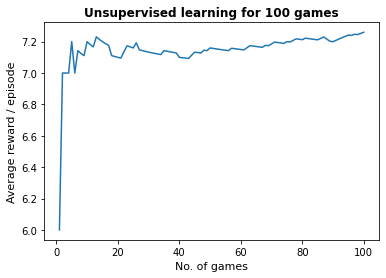

In [26]:
# start time of each test run
start = time.time()

# create environment
env = DoubleInvertedPendulum()
# number of samples processed before the model is updated
batch_size = 5 
# a full training pass over the entire dataset such that each example has been seen once
num_epochs = 4 
# controls the rate or speed at which the model learns
learning_rate_alpha = 3e-4

# create agent
agent = Agent(num_actions=env.action_space.n, batch_size=batch_size, 
                learning_rate_alpha=learning_rate_alpha, num_epochs=num_epochs, 
                input_dimensions=env.observation_space.shape)

# number of games
num_games = 100
# track best score: minimum score for the environment
best_score = env.reward_range[0]
# record score history
score_history = []
# a reward function that informs the agent how well its current actions and states are doing
learn_iters = 0
# track average score
average_score = 0
# number of steps means using one batch size of training data to train the model
num_steps = 0

for i in range(num_games):
    observation = env.reset()
    terminal_flag = False
    score = 0
    while not terminal_flag:
        # choose action based on the current state of the environment
        action, probability, value = agent.action_choice(observation)
        # get information back from environment
        observation_, reward, terminal_flag, info = env.step(action)
        # update step
        num_steps += 1
        # update score based on current reward
        score += reward

        # store transition in the agent memory
        agent.interface_agent_memory(observation, action, probability, value, reward, terminal_flag)
        if num_steps % num_steps == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    average_score = np.mean(score_history[-100:])
    
    if average_score > best_score:
        best_score = average_score
    
    # format output
    if i+1 < 10:
        print('episode: ', i+1, '  |  score: %.0f' % score)
    elif i+1 < 100:
        print('episode: ', i+1, ' |  score: %.0f' % score)   
    else:
        print('episode: ', i+1, '|  score: %.0f' % score)  
    
episodes = [i+1 for i in range(len(score_history))]
# end time of each test run
end = time.time()
# display time taken by test run
print('---------')
exec_time(start,end)
print('---------')
print(f"Total reward for {num_games} unsupervised episodes: {sum(score_history)}")
print('---------')
# visualise learning

def plot_learning_curve(episode, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(episode, running_avg)
    plt.title(f"Unsupervised learning for {num_games} games", fontweight='bold')
    plt.xlabel('No. of games', fontsize=11)
    plt.ylabel('Average reward / episode', fontsize=11)
    
plot_learning_curve(episodes, score_history)

## 5. Conclusion <a class="anchor" id="conclusion"></a> [☝](#contents)

Various starting angle combinations were tried. Additionally, different parameters were modulated to observe the agent's behaviour.

#### Initial Parameters:

<img src="images/tests/init_params.png" align="center" alt="initialisation_parameters" style="width: 500px"/>

### 5.1. $\theta = 0.05,\;\;\phi = 0.05$ <a class="anchor" id="conclusion-1"></a> [☝](#contents)

|  |  |
| :-: | :-: | 
| <img src="images/tests/set_1/100_games.png" alt="100_games" style="width: 400px"/> | <img src="images/tests/set_1/250_games.png" alt="250_games" style="width: 400px"/> | 
| <img src="images/tests/set_1/500_games.png" alt="500_games" style="width: 400px"/> | <img src="images/tests/set_1/1000_games.png" alt="1000_games" style="width: 400px"/> |
| <img src="images/tests/set_1/2500_games.png" alt="2500_games" style="width: 400px"/> | <img src="images/tests/set_1/5000_games.png" alt="5000_games" style="width: 400px"/> |

<img src="images/tests/set_1/10000_games.png" align="center" alt="10000_games" style="width: 400px"/>

### 5.2. $\theta = 0.10,\;\;\phi = 0.10$ <a class="anchor" id="conclusion-2"></a> [☝](#contents)

|  |  |
| :-: | :-: | 
| <img src="images/tests/set_2/100_games.png" alt="100_games" style="width: 400px"/> | <img src="images/tests/set_2/250_games.png" alt="250_games" style="width: 400px"/> | 
| <img src="images/tests/set_2/500_games.png" alt="500_games" style="width: 400px"/> | <img src="images/tests/set_2/1000_games.png" alt="1000_games" style="width: 400px"/> |
| <img src="images/tests/set_2/2500_games.png" alt="2500_games" style="width: 400px"/> | <img src="images/tests/set_2/5000_games.png" alt="5000_games" style="width: 400px"/> |

<img src="images/tests/set_2/10000_games.png" align="center" alt="10000_games" style="width: 400px"/>

### 5.3. $\theta = 0.15,\;\;\phi = 0.15$ <a class="anchor" id="conclusion-3"></a> [☝](#contents)

|  |  |
| :-: | :-: | 
| <img src="images/tests/set_3/100_games.png" alt="100_games" style="width: 400px"/> | <img src="images/tests/set_3/250_games.png" alt="250_games" style="width: 400px"/> | 
| <img src="images/tests/set_3/500_games.png" alt="500_games" style="width: 400px"/> | <img src="images/tests/set_3/1000_games.png" alt="1000_games" style="width: 400px"/> |
| <img src="images/tests/set_3/2500_games.png" alt="2500_games" style="width: 400px"/> | <img src="images/tests/set_3/5000_games.png" alt="5000_games" style="width: 400px"/> |

<img src="images/tests/set_3/10000_games.png" align="center" alt="10000_games" style="width: 400px"/>